In [1]:
import os.path

import torch
import wandb
import torchvision
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torchvision.datasets import MNIST
import torch.nn.functional as F
from tqdm import tqdm
from safetensors.torch import save_file, load_file


# Customs
from helpers import load_encoded_dataset, encode_dataset
from helpers import rk4_step, integrate_path, warp_time, BasicModel
from helpers import plot_latent_space, comparative_generate_samples, plot_generated

from models import ResNetVAE, log_example_images, InspoResNetVAE
from models import SimpleFlowModel, FlatVelocityNet, ConvFlowNet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model_save_path = 'models/safetensors/'

wandb.login()
wandb.finish()

wandb: Currently logged in as: marcocassar (marcocassar-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])
train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)

Data set lengths: train: 60000, test: 10000


### VAE

In [29]:
project = "vae_conv_testing"
recon_criterion = F.binary_cross_entropy_with_logits

def train_vae(
    model, train_loader, val_loader, name=None,
    epochs=20, lr=2e-3, weight_decay=5e-5,
    beta_final=0.005, warmup_epochs=10, grad_clip=5.0, ema=0.97, spatial=False
):
    device = next(model.parameters()).device

    # ---- W&B ----
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam",
        "device": str(device),
    })

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    global_step = 0
    train_loss_avg = None

    for epoch in range(epochs):
        model.train()

        beta = beta_final * min((epoch + 1) / warmup_epochs, 1.0)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()

            z, x_hat, mu, log_var, z_hat = model(data)

            recon_loss = recon_criterion(x_hat, data, reduction="sum") / data.size(0)
            
            kl = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
            kl = kl.view(kl.size(0), -1).sum(dim=1).mean()
            
            loss = recon_loss + beta * kl

            # loss, recon_loss, kl = vae_loss(data, x_hat, mu, log_var, beta)

            loss.backward()
            # if grad_clip is not None:
            #     clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            train_loss_avg = loss.item() if train_loss_avg is None else ema * train_loss_avg + (1 - ema) * loss.item()

            wandb.log({
                "step": global_step,
                "train_loss_ema": train_loss_avg,
                "train_loss": loss.item(),
                "recon_loss": recon_loss.item(),
                "kl_loss": kl.item(),
                "beta": beta,
                "beta*kl": (beta * kl).item(),
            })
            global_step += 1
            pbar.set_postfix(Loss=f"{train_loss_avg:.4f}", Recon=f"{recon_loss.item():.4f}", KLw=f"{(beta*kl).item():.5f}")

        # ---- validation ----
        model.eval()
        val_loss = val_recon = val_kl = 0.0
        mu_stats = []

        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                z, x_hat, mu, log_var, z_hat = model(data)

                recon = recon_criterion(x_hat, data)
                kl = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
                loss = recon + beta * kl

                val_loss += loss.item(); val_recon += recon.item(); val_kl += kl.item()
                mu_stats.append(mu)

        n = len(val_loader)
        val_loss /= n; val_recon /= n; val_kl /= n

        mu_all = torch.cat(mu_stats, dim=0)
        mu_mean = mu_all.mean().item(); mu_std = mu_all.std().item()

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_recon_loss": val_recon,
            "val_kl_loss": val_kl,
            "mu_mean": mu_mean,
            "mu_std": mu_std,
        })
        # print(f"Epoch {epoch+1:02d} | beta {beta:.3f} | val {val_loss:.4f} | recon {val_recon:.4f} | KL {val_kl:.4f} | μ_mean {mu_mean:.3f} μ_std {mu_std:.3f}")

        # visualize with sigmoid at eval-time only
        log_example_images(model, val_loader.dataset, epoch + 1, spatial=spatial, n=5)

    wandb.finish()
    return val_loss

In [25]:
specifications = {
    "base_channels": 16, 
    "blocks_per_level": 2, 
    "groups": 1
}
vae = InspoResNetVAE(latent_dim=13, **specifications).to(device)
# latent_dim=3, act=nn.GELU, use_skips=True, use_bn=True, base_channels=32, blocks_per_level=3, groups=1, dropout=0.4

AttributeError: 'function' object has no attribute 'name'

In [27]:
total_params = sum(p.numel() for p in vae.parameters())
trainable_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 439,899
Trainable parameters: 439,899


In [28]:
suffix = 'l13_base_16_block_2'
run_name = f"vae_test_{suffix}"
train_vae(vae, train_dl, test_dl, name=run_name, epochs=20, warmup_epochs=5, beta_final=1, spatial=False)

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.48it/s, KLw=5.44539, Loss=116.9236, Recon=108.9607]


Epoch 01 | beta 0.200 | val 0.5429 | recon 0.1315 | KL 2.0568 | μ_mean 0.009 μ_std 0.963


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.81it/s, KLw=9.79559, Loss=106.5275, Recon=97.9514]


Epoch 02 | beta 0.400 | val 0.8736 | recon 0.1177 | KL 1.8897 | μ_mean 0.070 μ_std 0.984


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.50it/s, KLw=13.57133, Loss=106.0327, Recon=95.5519]


Epoch 03 | beta 0.600 | val 1.1313 | recon 0.1113 | KL 1.6999 | μ_mean 0.075 μ_std 0.971


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.85it/s, KLw=16.65706, Loss=108.3612, Recon=90.8125]


Epoch 04 | beta 0.800 | val 1.3945 | recon 0.1101 | KL 1.6055 | μ_mean 0.026 μ_std 0.977


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.15it/s, KLw=19.11637, Loss=109.6420, Recon=89.8283]


Epoch 05 | beta 1.000 | val 1.5754 | recon 0.1080 | KL 1.4674 | μ_mean 0.028 μ_std 0.954


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.48it/s, KLw=19.41297, Loss=109.7993, Recon=89.7370]


Epoch 06 | beta 1.000 | val 1.6048 | recon 0.1103 | KL 1.4945 | μ_mean 0.060 μ_std 0.965


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.05it/s, KLw=18.83092, Loss=109.2517, Recon=101.4777]


Epoch 07 | beta 1.000 | val 1.5527 | recon 0.1086 | KL 1.4441 | μ_mean 0.062 μ_std 0.956


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.92it/s, KLw=19.03676, Loss=106.3567, Recon=83.9062]


Epoch 08 | beta 1.000 | val 1.6047 | recon 0.1050 | KL 1.4997 | μ_mean 0.072 μ_std 0.955


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.38it/s, KLw=19.50803, Loss=106.1072, Recon=84.4654]


Epoch 09 | beta 1.000 | val 1.5973 | recon 0.1026 | KL 1.4947 | μ_mean 0.056 μ_std 0.942


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.04it/s, KLw=19.21808, Loss=105.0795, Recon=83.6706]


Epoch 10 | beta 1.000 | val 1.5726 | recon 0.1035 | KL 1.4691 | μ_mean 0.016 μ_std 0.931


Epoch 11/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.60it/s, KLw=19.76348, Loss=104.3175, Recon=82.0055]


Epoch 11 | beta 1.000 | val 1.6110 | recon 0.1017 | KL 1.5093 | μ_mean 0.048 μ_std 0.937


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.65it/s, KLw=20.07477, Loss=104.4900, Recon=84.7824]


Epoch 12 | beta 1.000 | val 1.6049 | recon 0.1040 | KL 1.5009 | μ_mean 0.050 μ_std 0.935


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.98it/s, KLw=19.84205, Loss=104.2154, Recon=83.5435]


Epoch 13 | beta 1.000 | val 1.6137 | recon 0.1046 | KL 1.5091 | μ_mean 0.055 μ_std 0.957


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.30it/s, KLw=19.45408, Loss=103.2643, Recon=81.8969]


Epoch 14 | beta 1.000 | val 1.5938 | recon 0.1019 | KL 1.4919 | μ_mean 0.017 μ_std 0.927


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.49it/s, KLw=19.23122, Loss=102.4357, Recon=80.6137]


Epoch 15 | beta 1.000 | val 1.6036 | recon 0.1005 | KL 1.5031 | μ_mean 0.042 μ_std 0.935


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.20it/s, KLw=20.41448, Loss=102.1048, Recon=88.4168]


Epoch 16 | beta 1.000 | val 1.6151 | recon 0.0993 | KL 1.5158 | μ_mean 0.051 μ_std 0.942


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 42.01it/s, KLw=19.97803, Loss=100.9263, Recon=77.9758]


Epoch 17 | beta 1.000 | val 1.6286 | recon 0.0998 | KL 1.5288 | μ_mean 0.048 μ_std 0.940


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 43.81it/s, KLw=20.60246, Loss=100.9268, Recon=81.2446]


Epoch 18 | beta 1.000 | val 1.6508 | recon 0.0987 | KL 1.5520 | μ_mean 0.039 μ_std 0.945


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.31it/s, KLw=20.90116, Loss=101.3603, Recon=82.2595]


Epoch 19 | beta 1.000 | val 1.6466 | recon 0.0974 | KL 1.5492 | μ_mean 0.043 μ_std 0.946


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 34.12it/s, KLw=20.53725, Loss=100.6253, Recon=77.9656]


Epoch 20 | beta 1.000 | val 1.6417 | recon 0.0984 | KL 1.5434 | μ_mean 0.025 μ_std 0.940


beta,▁▁▁▃▅▅▆▆████████████████████████████████
beta*kl,▁▄▄▄▄▇▇▇▇▇████▇█████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
kl_loss,▁▅██▆▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
mu_mean,▁▇█▃▃▆▇█▆▂▅▅▆▂▄▅▅▄▅▃
mu_std,▅█▆▇▄▆▅▄▃▂▂▂▅▁▂▃▃▃▃▃
recon_loss,█▅▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁
step,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
train_loss,█▃▄▂▃▃▄▄▃▃▂▂▃▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▃▂▂▁▂▁▁▁▂▁▂▁
train_loss_ema,█▇▅▃▅▃▅▅▅▅▅▄▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
+3,...


1.6417367926126794

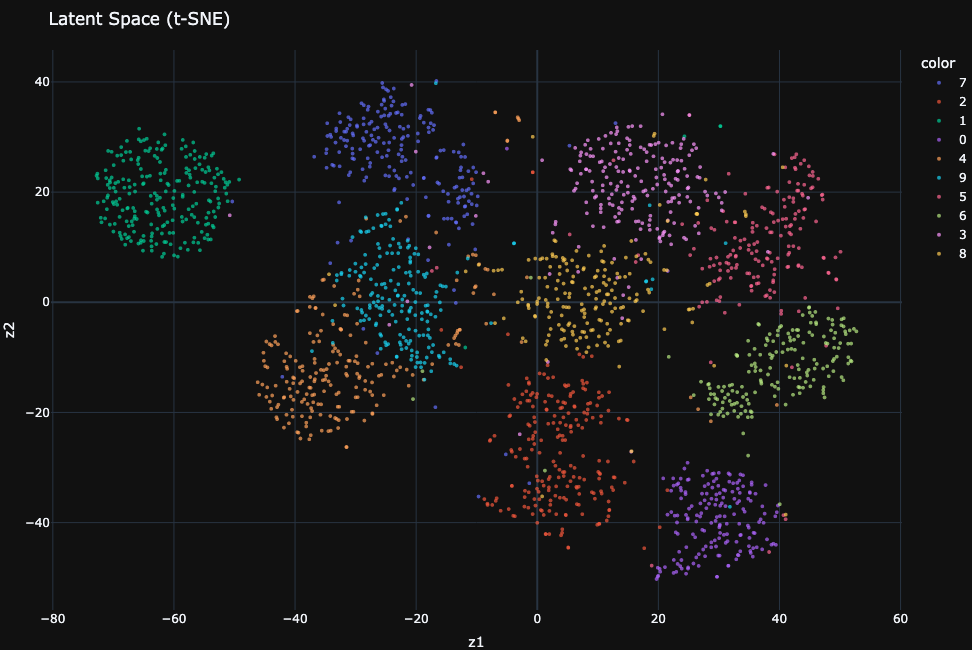

In [31]:
plot_latent_space(vae, test_dl, use_3d=False, reducer='tsne')

In [32]:
vae_save_name =  f'{vae.__class__.__name__}_{run_name}'
vae_path = os.path.join(model_save_path, f'vae/{vae_save_name}.safetensors')
if os.path.exists(vae_path):
    print(f"Path: {vae_path} \n already exists! Appending run_id to make unique")
    vae_path = vae_path.split('.safetensors')[0] + str(wandb.run.id) + '.safetensors'
print(f"Saving to: {vae_path}")

Saving to: models/safetensors/vae/InspoResNetVAE_vae_test_l13_base_16_block_2.safetensors


In [33]:
save_file(vae.state_dict(), vae_path)

### Encode VAE

In [34]:
vae.eval()
encode_dataset(vae, train_dl, test_dl, suffix=suffix)

Processing train split...



Loader: MNIST train Batch 469/469: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 251.02it/s]


Processing test split...



Loader: MNIST test Batch 79/79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 243.78it/s]


### Flow Matching

In [ ]:
# load vae if needed
name_of_vae_tensor = 'sp_vae.safetensors'
path_to_vae = os.path.join(model_save_path, '/vae/', name_of_vae_tensor)
vae = ResNetVAE().to(device)
vae.load_state_dict(load_file(vae_path))
vae.eval()

In [35]:
# load latent encoded data
latent_data_path = os.path.join('data', vae.encoder.__class__.__name__ + '_' + suffix + '/MNIST/')
latent_train_ds, latent_test_ds = load_encoded_dataset(latent_data_path)
latent_train_dl = DataLoader(latent_train_ds, batch_size=batch_size, shuffle=True)
latent_test_dl  = DataLoader(latent_test_ds, batch_size=batch_size, shuffle=False)

In [36]:
project = 'dl_experimentation'
def train_flow(model, train_loader, test_loader, name='flow_model', pretrained_model=None, epochs=20, lr=0.001, warp_fn=None, new_points_every=1, spatial=True):
    wandb.finish()
    wandb.init(project=project, name=name, reinit='finish_previous')
    wandb.config.update({
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": lr,
        "model": model.__class__.__name__,
        "optimizer": "Adam"
    })

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    global_step = 1

    for epoch in range(epochs):
        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)

        for batch_idx, (data, _) in enumerate(pbar):
            optimizer.zero_grad()

            # Get data and create a sample from it to calc movement
            target_x = data.to(device)
            sampled_x = torch.randn_like(target_x)
            B = sampled_x.size(0)

            if global_step % new_points_every == 0:
                if pretrained_model:   # ReFlow
                    target_x = integrate_path(pretrained_model, sampled_x, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)

            t  = torch.rand(B, 1, device=sampled_x.device, dtype=sampled_x.dtype)

            if warp_fn: t = warp_fn(t)
            
            if spatial: 
                # t4 = torch.zeros_like(sampled_x) + t
                t4 = t.view(B, 1, 1, 1)
                interpolated_x = sampled_x * (1 - t4) + target_x * t4
            else:
                interpolated_x = sampled_x * (1-t) + target_x * t

            
            line_directions = target_x - sampled_x
            
            drift = model(interpolated_x, t)
            loss = criterion(drift, line_directions)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                cos_sim = F.cosine_similarity(drift, line_directions, dim=1).mean()

            wandb.log({
                "step": global_step,
                "train_loss": loss.item(),
                "cos_sim": cos_sim.item(),
                "drift": drift.norm(dim=1).mean().item(),
            })
            global_step += 1

    return model

In [37]:
flow = FlatVelocityNet(13).to(device)

In [40]:
flow_name = f'flow_{suffix}'
train_flow(flow, latent_train_dl, latent_test_dl, name=flow_name, epochs=100, spatial=False)

In [41]:
flow_save_name =  f'{flow.__class__.__name__}_{flow_name}'
flow_path = os.path.join(model_save_path, f'flow/{flow_save_name}.safetensors')
if os.path.exists(flow_path):
    print(f"Path: {flow_path} \n already exists! Appending run_id to make unique")
    flow_path = flow_path.split('.safetensors')[0] + str(wandb.run.id) + '.safetensors'
print(f"Saving to: {flow_path}")

Saving to: models/safetensors/flow/FlatVelocityNet_flow_l13_base_16_block_2.safetensors


In [42]:
save_file(flow.state_dict(), flow_path)

#### Pretrained Model

In [ ]:
name_of_flow_tensor = 'flow_2.safetensors'
path_to_flow = os.path.join(model_save_path, '/flow/', name_of_flow_tensor)

In [ ]:
teacher_flow = ConvFlowNet(1).to(device)
teacher_flow.load_state_dict(load_file())

#### Visualize Flow

In [43]:
basic = BasicModel(vae, flow, (13,)).to(device)

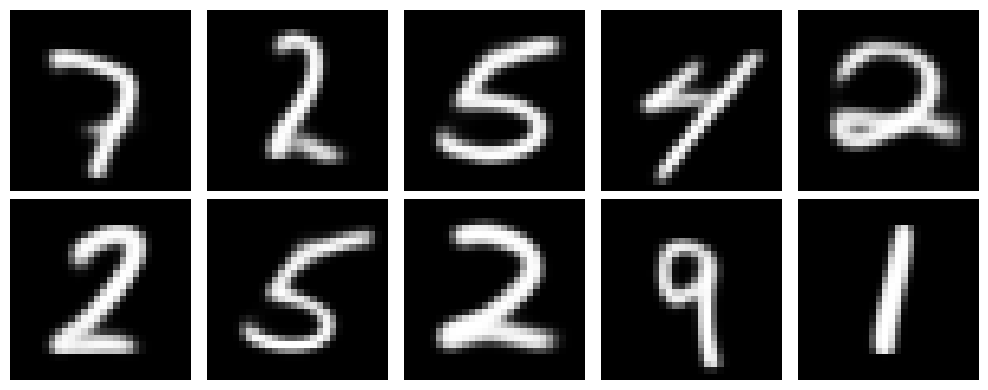

In [70]:
samples = basic.generate_samples(10, 15)
plot_generated(samples)

In [56]:
## For comparing two flows
x1, x2 = comparative_generate_samples(flow1, flow2, vae, 5, 10)
print("Normal Flow")
plot_generated(x1)
print("Re Flow")
plot_generated(x2)

NameError: name 'flow1' is not defined